In [ ]:
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

Looking in indexes: https://download.pytorch.org/whl/cu118, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install transformers requests beautifulsoup4 pandas numpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import requests
from bs4 import BeautifulSoup
import re

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')
model = AutoModelForSequenceClassification.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')

In [ ]:
# forming tokens for a sentence
tokens = tokenizer.encode('It is the worst product not worth the money', return_tensors='pt')

In [ ]:
tokens

tensor([[  101, 10197, 10127, 10103, 43060, 20058, 10497, 25840, 10103, 15033,
           102]])

In [ ]:
result = model(tokens)

In [ ]:
result

SequenceClassifierOutput(loss=None, logits=tensor([[ 4.7221,  2.3033, -0.2095, -2.7809, -3.1302]],
       grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

In [ ]:
result.logits

tensor([[ 4.7221,  2.3033, -0.2095, -2.7809, -3.1302]],
       grad_fn=<AddmmBackward0>)

In [ ]:
# sentiment value
torch.argmax(result.logits)

tensor(0)

In [ ]:
# sentiment value 1-5
int(torch.argmax(result.logits))+1

1

In [ ]:
HEADERS = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:98.0) Gecko/20100101 Firefox/98.0",
        "Accept": "text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,*/*;q=0.8",
        "Accept-Language": "en-US,en;q=0.5",
        "Accept-Encoding": "gzip, deflate",
        "Connection": "keep-alive",
        "Upgrade-Insecure-Requests": "1",
        "Sec-Fetch-Dest": "document",
        "Sec-Fetch-Mode": "navigate",
        "Sec-Fetch-Site": "none",
        "Sec-Fetch-User": "?1",
        "Cache-Control": "max-age=0",
    }
# Access denied using headers for accessing the web site.
# reviews are there in different pages
pages=[]
for page in range(1, 50):
  try:
    url = f'https://www.zomato.com/visakhapatnam/pizza-store-kurmannapalem-vizag/reviews?page={page}&amp;sort=dd&amp;filter=reviews-dd'
    r = requests.get(url, headers=HEADERS)
    pages.append(r)
  except:
    break
# review class pattern
pattern = re.compile(r'sc-1hez2tp-0\s(sc-fxMfqs|sc-cBOTKl)\s(jBfxuu|koyCoy)')
regex = re.compile(pattern)
soups = []
for page in pages:
  soup = BeautifulSoup(page.text, 'html.parser')
  results = soup.find_all('p', {'class':regex})
  if len(results)>0:
    soups.append(results)


In [ ]:
reviews = []
for soup in soups:
  for p in soup:
    review = p.text
    # ignoring unnecessary reviews with 0 lenght
    if len(review)>0:
      reviews.append(review)

[' the worst... money wast', 'The taste is very bad. money wasted ', 'Worst experience by ordering in Zomato ', 'not at all good', 'Sandwich is not good', 'taste was awesome 😋', 'super ', 'Restaurant unfit to sell their products. Person who cook watching a youtube tutorial can cook better than them', 'damage pice bad quality ', 'pizza very cold', 'wested ', 'It was disgusting....not even dogs will eat...it was so worst..the milkshake smells so bad and tastes just like water', 'taste was tooo  bad', 'pizza was cold and crust was missing. The French fries were awful.. bad taste and soft. Not satisfied', 'Orgeno miss', '..', "worest taste and item's missing", 'Worst taste', 'yummyyyyy ..very tasty..veey good packaging..nice', 'this is not a butterscotch milkshake, minimum test less', 'Worst pizza i have ever eat it is very tasteless and very cold and not hot worst pizza very tasteless ', 'wrost taste low quality waste money waste of time ']
22


In [ ]:
import numpy as np
import pandas as pd

In [ ]:
df = pd.DataFrame(np.array(reviews), columns=['review'])

In [ ]:
df['review'].iloc[0]

'Not a good taste, less portion of chicken compared to price.'

In [ ]:
# sentiment_score function returns sentiment score.
def sentiment_score(review):
    tokens = tokenizer.encode(review, return_tensors='pt')
    result = model(tokens)
    return int(torch.argmax(result.logits))+1

In [ ]:
sentiment_score(df['review'].iloc[1])

1

In [ ]:
# storing sentiment scores of each review in df using the above function.
df['sentiment'] = df['review'].apply(lambda x: sentiment_score(x[:512]))

In [ ]:
# Contains reviews and their sentiment scores.
df

,review,sentiment
0,the worst... money wast,1
1,The taste is very bad. money wasted,1
2,Worst experience by ordering in Zomato,1
3,not at all good,1
4,Sandwich is not good,1
5,taste was awesome 😋,5
6,super,5
7,Restaurant unfit to sell their products. Perso...,1
8,damage pice bad quality,1
9,pizza very cold,2


In [ ]:
labeldf = pd.DataFrame({
    'Reviews': [i for i in range(0, df.shape[0])],
    'Sentiment': df['sentiment']
})

In [ ]:
import matplotlib.pyplot as plt

<Axes: xlabel='Reviews'>

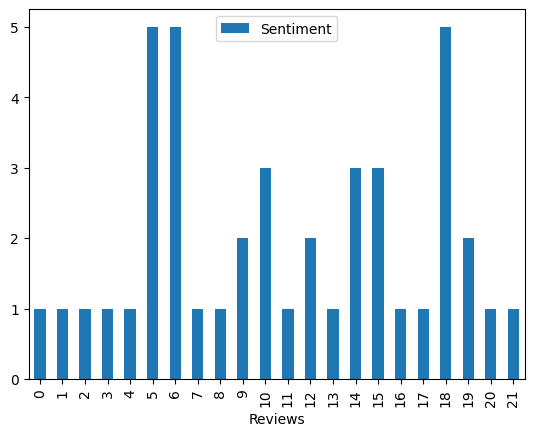

In [ ]:
# visual representation of reviews and sentiments
labeldf.plot(x="Reviews", y="Sentiment", kind="bar")